# News Sentiment Analysis

## Import Libraries

In [1]:
# // TODO: TINGS
#     ✓ Find API for data collection
#     ✓ Data Gathering
#     ✓ Data Cleaning
#     - Feature generation
#     - Feature Engineering/selection
#     - Model Train
#     - Model Test
#     - Model Evaluation

In [2]:
# Common Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import glob
import re
from IPython.display import clear_output
import time
import random

# Cleaner output
from tqdm import tqdm

# Deep Learning Libraries
import torch

# Add the path to the API Scraper
## Project Path
project_path = "../"

## Add the path to API Scraper
sys.path.append(os.path.abspath(os.path.join(project_path, "lib")))

# Custom News Libraries
from scraper import get_cached_news_metadata, extract_text_from_url

# Text preprocessing
from preprocessor import clean_text

## Fetch Data

In [3]:
def scrape_data(n_request: int = 10, before_date: str = "2025-12", path: str = ".", last_idx:int = 0) -> pd.DataFrame:
    
    articles = []

    for i in tqdm(range(last_idx, last_idx + n_request), desc="Fetching News Data...", unit="news"):
        metadata = get_cached_news_metadata(page=i, before_date=before_date, path=path)

        data_list = metadata.get("data", [])

        for article in data_list:
            # extract sentiment (first entity if exists)
            entities = article.get("entities", [])
            if entities and "sentiment_score" in entities[0]:
                sentiment = entities[0]["sentiment_score"]
            else:
                sentiment = None

            # store sentiment as its own field inside article
            article["sentiment"] = sentiment

            articles.append(article)

    # final dataframe
    return pd.DataFrame(articles)

### Caching

In [ ]:
# Arguments for the caching function
before_date = "2025-11"

data_path = os.path.join(project_path,f"news_cache/{before_date}/csv/")
os.makedirs(data_path, exist_ok=True) # if the directory exist no need to make

cached_file = os.path.join(data_path, f"{before_date}_news_data.csv")

# Set this to TRUE if you want to get new data/overwrite the old data
overwrite_cached_links = False

# get the last index of the file 
json_files = os.path.join(project_path, f"news_cache/{before_date}/json/page-*.json")
list_of_files = glob.glob(json_files)

## Extract page numbers set to True if you want to get new api request.
get_new_requests = False

if get_new_requests:
    page_nums = []
    for f in list_of_files:
        match = re.search(r"page-(\d+)\.json$", os.path.basename(f))
        if match:
            page_nums.append(int(match.group(1)))

    last_idx = max(page_nums)
    n_requests = 101 # marketaux api limit (last index is excluded)

else:
    last_idx = 0
    n_requests = len(list_of_files) #number of pages we cached to be processed

In [5]:
# TODO: page 339 has problems
# get_cached_news_metadata(page=339, before_date=before_date, path=project_path)

In [6]:
# filling missing text data function

def safe_extract(row):
    try:
        text = extract_text_from_url(row["url"])
        # print(f"{row['title']} {row['description']}")
        return text

    except Exception as e:
        tqdm.write(f"failed to extract from url \n Err: {e} \n appending title and description")
        time.sleep(2)
        print(f"{row['title']} {row['description']}")
        clear_output(wait=True)
        text = f"{row['title']} {row['description']}"
        return text

In [7]:
# tqdm for cleaner output
tqdm.pandas(desc="Extracting News from URL's", unit="news")

# We will cache the data so that it will load faster
if os.path.exists(cached_file) and not overwrite_cached_links:
    print("Loading cached dataset...")
    news_df = pd.read_csv(cached_file, sep = ',')
    print("Cached dataset loaded")

elif os.path.exists(cached_file) and overwrite_cached_links:
    print("Overwriting old data and caching new data...")
    # Scrape the data
    news_df = scrape_data(n_request=n_requests, before_date= before_date, path= project_path, last_idx=last_idx)
    
    # Extract text from the news
    news_df["text"] = news_df.progress_apply(safe_extract, axis=1)
    news_df.to_csv(cached_file, index=False)
    print("Done Overwriting old data and caching new data...")

else:
    print("Creating and caching dataset...")
    news_df = scrape_data(n_request=n_requests, before_date= before_date, path= project_path, last_idx=last_idx)
    news_df["text"] = news_df.progress_apply(safe_extract, axis=1)
    news_df.to_csv(cached_file, index=False)
    print("Finished Caching")

Extracting News from URL's:  56%|█████▌    | 5211/9279 [3:45:39<2:56:09,  2.60s/news] 


KeyboardInterrupt: 

### Fetch the Text from URL

## EDA

### View the Data

In [ ]:
news_df.head(10)

,uuid,title,description,keywords,snippet,url,image_url,language,published_at,source,relevance_score,entities,similar,sentiment,text
0,14cd2d6a-535b-4792-8c70-6eb795dbaf7d,Dow gives mixed Q3 results (NYSE:DOW),Dow's Q3 earnings beat expectations despite re...,,"To ensure this doesn’t happen in the future, p...",https://seekingalpha.com/news/4507334-dow-give...,https://static.seekingalpha.com/assets/og_imag...,en,2025-10-23T10:04:57.000000Z,seekingalpha.com,None,"[{'symbol': 'DOW', 'name': 'Dow Inc.', 'exchan...",[],0.00000,
1,3c5b14b3-ed82-42ef-92ae-d60ec0cc1f02,Colgate-Palmolive: Shine Still Missing After T...,"Colgate-Palmolive shows weak growth, high valu...",,"On 14 July 2025 , my first article about Colga...",https://seekingalpha.com/article/4832291-colga...,https://static.seekingalpha.com/cdn/s3/uploads...,en,2025-10-23T10:03:55.000000Z,seekingalpha.com,None,"[{'symbol': 'CL', 'name': 'Colgate-Palmolive C...",[],0.17630,
2,1adf9a00-ee1f-4aaf-931c-5b47011b608c,Quantum computing firms jump after report of U...,"Shares of US quantum computing firms, includin...","quantum computing, US government stake talks, ...",Shares in US quantum computing firms surged in...,https://economictimes.indiatimes.com/tech/tech...,"https://img.etimg.com/thumb/width-1200,height-...",en,2025-10-23T10:03:14.000000Z,economictimes.indiatimes.com,None,"[{'symbol': 'QTUM', 'name': 'Defiance Quantum ...",[],0.47785,Synopsis\n\nShares of US quantum computing fir...
3,7baf2a85-dd93-4eb2-b9de-b5ff3f6275c2,Japanese Companies Brace for More Attacks as C...,The recent wave of cyberattacks against Japane...,,The recent wave of cyberattacks against Japane...,https://www.insurancejournal.com/news/internat...,https://www.insurancejournal.com/app/uploads/2...,en,2025-10-23T10:03:01.000000Z,insurancejournal.com,None,"[{'symbol': 'ASBRF', 'name': 'Asahi Group Hold...",[],-0.90420,The recent wave of cyberattacks against Japane...
4,12890f38-0797-4e2b-8e3f-b98cc33bd9bd,Dassault Systèmes SE 2025 Q3 - Results - Earni...,2025-10-23. The following slide deck was publi...,,"To ensure this doesn’t happen in the future, p...",https://seekingalpha.com/article/4832320-dassa...,https://static.seekingalpha.com/assets/og_imag...,en,2025-10-23T10:01:38.000000Z,seekingalpha.com,None,"[{'symbol': 'DASTY', 'name': 'Dassault Système...",[],0.00000,
5,8e1266ac-7248-4032-ac87-bd864a44b49f,Indian Refiners Plan Major Russian Oil Cuts Af...,Indian refiners plan to sharply cut Russian oi...,,"The U.S. sanctioned Rosneft and Lukoil, two of...",https://www.benzinga.com/news/politics/25/10/4...,https://cdn.benzinga.com/files/images/story/20...,en,2025-10-23T10:01:30.000000Z,benzinga.com,None,"[{'symbol': 'RELIANCEPP.BO', 'name': 'Reliance...",[],-0.33700,"The U.S. sanctioned Rosneft and Lukoil, two of..."
6,1f7bc97b-3c93-4e84-9948-a1c4fff76342,Primech AI and Savills Launch HYTRON Autonomou...,**media[795163]**,"Primech, AI, and, Savills, Launch, HYTRON, Aut...",SINGAPORE - Media OutReach Newswire - 23 Octob...,https://www.manilatimes.net/2025/10/23/tmt-new...,https://www.manilatimes.net/manilatimes/upload...,en,2025-10-23T10:01:14.000000Z,manilatimes.net,None,"[{'symbol': 'NVDA', 'name': 'NVIDIA Corporatio...",[],0.77830,
7,230ef455-2bce-4eb8-b777-e42fd7865469,"Texas Capital Bancshares, Inc. 2025 Q3 - Resul...",2025-10-23. The following slide deck was publi...,,"To ensure this doesn’t happen in the future, p...",https://seekingalpha.com/article/4832318-texas...,https://static.seekingalpha.com/assets/og_imag...,en,2025-10-23T10:01:03.000000Z,seekingalpha.com,None,"[{'symbol': 'TCBI', 'name': 'Texas Capital Ban...",[],0.00000,
8,349b56f4-67eb-404e-ae5d-125b6d08f788,MP Stock To $150?,The recent decline has left investors ponderin...,"mp revenue, mp valuation, mp materials",CANADA - 2025/09/28: In this photo illustratio...,https://www.forbes.com/sites/greatspeculations...,https://imageio.forbes.com/specials-images/ima...,en,2025-10-23T10:00:57.000000Z,forbes.com,None,"[{'symbol': 'MP', 'name': 'M

### Check for Missing Values

In [ ]:
is_na = pd.DataFrame(news_df.isna().sum())
is_na.columns = ["Number_Missing"]
is_na["Missing_Percentage"] = (is_na["Number_Missing"] / len(news_df) * 100)
print(is_na)

                 Number_Missing  Missing_Percentage
uuid                          0                 0.0
title                         0                 0.0
description                   0                 0.0
keywords                      0                 0.0
snippet                       0                 0.0
url                           0                 0.0
image_url                     0                 0.0
language                      0                 0.0
published_at                  0                 0.0
source                        0                 0.0
relevance_score             303               100.0
entities                      0                 0.0
similar                       0                 0.0
sentiment                     0                 0.0
text                          0                 0.0


### Distribution of the Sentiment Scores

#### Plotting Functions

In [ ]:
#setting the colors generator
def fill_color_generator():
    """This generates a color

    Returns:
        color: An R,G,B value with a range of 0 to 1
    """
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    return (r/255, g/255, b/255)

#function for plotting numerical data distribution
def numeric_dist_plot(data: pd.DataFrame):
    """This function creates a plot of the distribution of the numerical data. 

    Args:
        data (pd.DataFrame): Numeric pandas dataframe

    Raises:
        TypeError: The following columns are not numeric: {non_numeric_cols}
        This is due to some of the columns are not numeric.

    Returns:
        Displays a plot of
    """
    # Checks
    ## Check if all columns are numeric
    non_numeric_cols = [col for col in data.columns if not pd.api.types.is_numeric_dtype(data[col])]
    if non_numeric_cols:
        raise TypeError(f"The following columns are not numeric: {non_numeric_cols}")
    
    # Plotting the numerical data
    #titles for plots/figures
    fig_titles = []

    for colName in data.columns:
        fig_titles.append(f"Boxplot Of {colName}")
        fig_titles.append(f"Histogram Of {colName}")
        
    fill_color_dict = {}
    for colName in data.columns:
        fill_color_dict[colName] = fill_color_generator()

    # make subplot for each column name
    num_rows = len(data.columns)
    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, num_rows * 3))

    # Flatten axes for easier indexing when there's more than 1 row
    axes = axes if num_rows > 1 else [axes]

    for i, column in enumerate(data.columns):
        color = fill_color_dict[column]

        # Boxplot
        axes[i][0].boxplot(data[column].dropna(), vert=False, patch_artist=True,
                        boxprops=dict(facecolor=color, color=color),
                        medianprops=dict(color="black"))
        axes[i][0].set_title(f"Boxplot of {column}")
        axes[i][0].set_xlabel(column)

        # Histogram
        axes[i][1].hist(data[column].dropna(), bins=20, color=color, alpha=0.7, edgecolor='black')
        axes[i][1].set_title(f"Histogram of {column}")
        axes[i][1].set_xlabel(column)

    # Overall layout
    fig.suptitle("Boxplot and Distribution Visualization", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to fit title
    return plt

#### Data Plots (Before Cleaning)

##### Sentiment Score Distribution

<module 'matplotlib.pyplot' from '/home/andrew/miniconda3/envs/text_mining_research-env/lib/python3.11/site-packages/matplotlib/pyplot.py'>

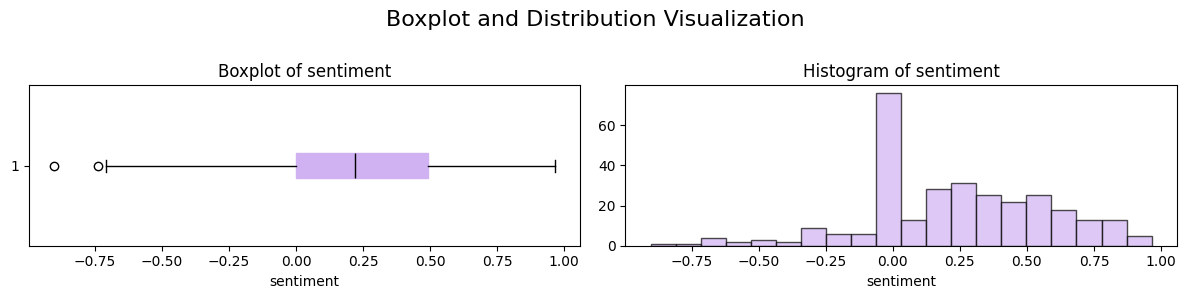

In [ ]:
numeric_dist_plot(pd.DataFrame(news_df["sentiment"]))

##### Word Count Distribution

<Axes: title={'center': 'Text_Length Distribution'}, xlabel='length', ylabel='Count'>

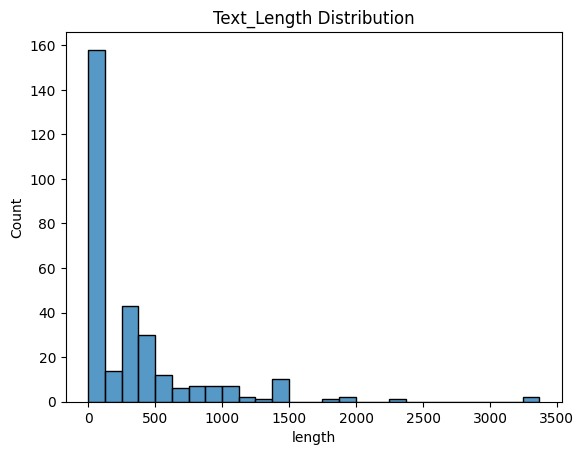

In [ ]:
news_df['text'] = news_df['text'].apply(str)
news_df['length'] = news_df['text'].str.split().apply(len)
plt.title("Text_Length Distribution")
sns.histplot(news_df['length'])

In [ ]:
news_df['length'].describe()

count     303.000000
mean      311.874587
std       483.458728
min         0.000000
25%         0.000000
50%        84.000000
75%       427.000000
max      3368.000000
Name: length, dtype: float64

## Data Cleaning

### Fix Missing Values

In [ ]:
news_df["text"] = news_df["text"].replace("", None)

In [ ]:
is_na = pd.DataFrame(news_df.isna().sum())
is_na.columns = ["Number_Missing"]
is_na["Missing_Percentage"] = (is_na["Number_Missing"] / len(news_df) * 100)
print(is_na)

                 Number_Missing  Missing_Percentage
uuid                          0            0.000000
title                         0            0.000000
description                   0            0.000000
keywords                      0            0.000000
snippet                       0            0.000000
url                           0            0.000000
image_url                     0            0.000000
language                      0            0.000000
published_at                  0            0.000000
source                        0            0.000000
relevance_score             303          100.000000
entities                      0            0.000000
similar                       0            0.000000
sentiment                     0            0.000000
text                        124           40.924092
length                        0            0.000000


In [ ]:
# Fill the missing text from the url with just the news description. due to the scraper is unable to get the html since the site requires authorization
news_df["text"] = news_df["text"].fillna(
    news_df["title"].fillna('') + " " + news_df["description"].fillna('')
)

In [ ]:
is_na = pd.DataFrame(news_df.isna().sum())
is_na.columns = ["Number_Missing"]
is_na["Missing_Percentage"] = (is_na["Number_Missing"] / len(news_df) * 100)
print(is_na)

                 Number_Missing  Missing_Percentage
uuid                          0                 0.0
title                         0                 0.0
description                   0                 0.0
keywords                      0                 0.0
snippet                       0                 0.0
url                           0                 0.0
image_url                     0                 0.0
language                      0                 0.0
published_at                  0                 0.0
source                        0                 0.0
relevance_score             303               100.0
entities                      0                 0.0
similar                       0                 0.0
sentiment                     0                 0.0
text                          0                 0.0
length                        0                 0.0


### Drop Duplicated Data

In [ ]:
news_df.duplicated().sum()

TypeError: unhashable type: 'list'

In [ ]:
news_df = news_df.drop_duplicates()

In [ ]:
news_df.duplicated().sum()

np.int64(0)

### Clean the Text

In [ ]:
# Arguments for the caching function
cleaned_data_path = os.path.join(project_path,f"news_cache/{before_date}/csv/")
os.makedirs(cleaned_data_path, exist_ok=True) # if the directory exist no need to make

clean_cached_file = os.path.join(cleaned_data_path, f"{before_date}_clean_news_data.csv")

# Set this to TRUE if you want to get new data/overwrite the old data
overwrite_clean_data = True

In [ ]:
# tqdm for cleaner output
tqdm.pandas(desc="Cleaning the Text", unit="news")

# We will cache the data so that it will load faster
if os.path.exists(clean_cached_file) and not overwrite_clean_data:
    print("Loading cached dataset...")
    news_df = pd.read_csv(clean_cached_file)
    print("Cached dataset loaded")

elif os.path.exists(clean_cached_file) and overwrite_clean_data:
    print("Overwriting old data and caching new data...")
    # Clean the data
    news_df["clean_text"] = news_df["text"].progress_apply(
                                                        lambda x: clean_text(
                                                            text = x,
                                                            tokenize=False,
                                                            remove_stop_words= True,
                                                            remove_emojis="keep"
                                                            )
                                                        )
    news_df.to_csv(clean_cached_file, index=False)
    print("Done Overwriting old data and caching new data...")

else:
    print("Creating and caching dataset...")
    # Clean the data
    news_df["clean_text"] = news_df["text"].progress_apply(
                                                        lambda x: clean_text(
                                                            text = x,
                                                            tokenize=False,
                                                            remove_stop_words= True,
                                                            remove_emojis="keep"
                                                            )
                                                        )
    news_df.to_csv(clean_cached_file, index=False)
    print("Finished Caching")

Overwriting old data and caching new data...


Cleaning the Text: 100%|██████████| 6367/6367 [00:03<00:00, 1894.78news/s]


Done Overwriting old data and caching new data...


##### Sentiment Score Distribution (After Cleaning)

<module 'matplotlib.pyplot' from '/home/andrew/miniconda3/envs/text_mining_research-env/lib/python3.11/site-packages/matplotlib/pyplot.py'>

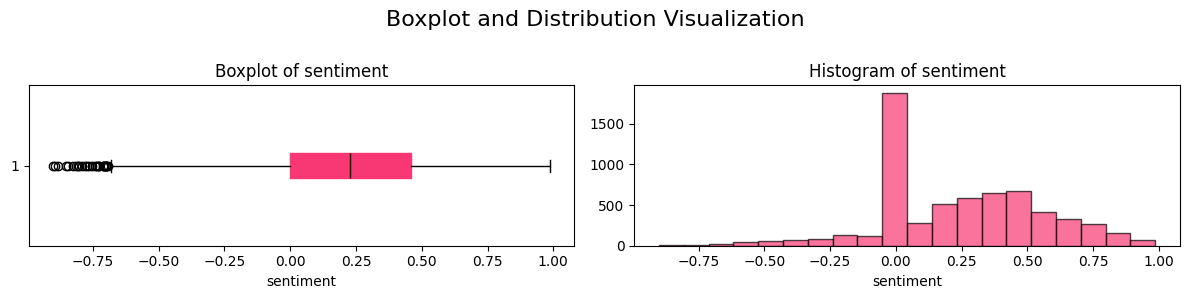

In [ ]:
numeric_dist_plot(pd.DataFrame(news_df["sentiment"]))

##### Word Count Distribution

<Axes: title={'center': 'Text_Length Distribution'}, xlabel='length', ylabel='Count'>

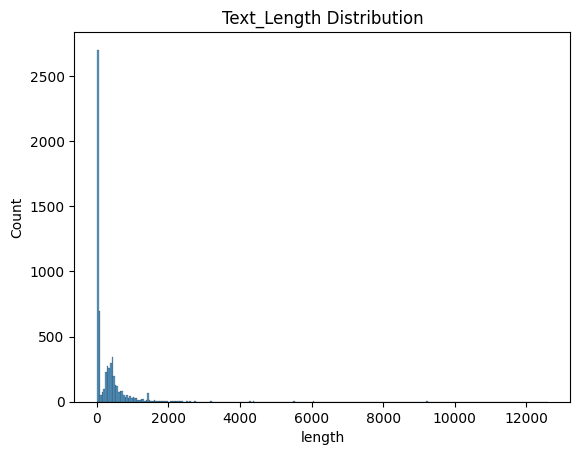

In [ ]:
news_df['text'] = news_df['text'].apply(str)
news_df['length'] = news_df['text'].str.split().apply(len)
plt.title("Text_Length Distribution")
sns.histplot(news_df['length'])

In [ ]:
news_df['length'].describe()

count     6367.000000
mean       323.853306
std        739.416798
min          1.000000
25%          1.000000
50%         89.000000
75%        422.000000
max      12606.000000
Name: length, dtype: float64